In [1]:
import pulp
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy


In [2]:
# Working through the hooks puzzles.
# Solving the matrix is fast using the same tools as the Feb 14 puzzle 
# this time I've managed to cut the number of possible grids down to 3200 from 65k 
# 16 times speed up when you factor in the cost of cutting down the grids
# also sorted out some confusion between row and col labels
# tried backtracking but was v. slow and doing a more sophisticated cut down of the 
# splits just makes it slower

url='https://www.janestreet.com/puzzles/hooks-2/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:]))

The grid below can be partitioned into 9 L-shaped “hooks”.  The largest is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains 15 squares), and so on.  The smallest hook is just a single square. Find where the hooks are located, and place nine 9’s in the largest hook, eight 8’s in the next-largest, etc., down to one 1 in the smallest hook. The goal is for the sum of the numbers in each row and column to match the number given outside the grid. As your answer to this puzzle, submit the largest product one can achieve using a subset of the numbered squares in the completed grid, satisfying the condition that no two squares in the subset are in the same row or column. © Copyright 2015-2021 Jane Street Group, LLC. All rights reserved. Services are provided in the U.S. by Jane Street Capital, LLC and Jane Street Execution Services, LLC, each of which is a SEC-registered broker dealer and member of FINRA (www.finra.org). Services are provided in Europe by Jane Street Financial

### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/05/may16_puzzle_expanded.png" width="500" height="600">

In [3]:
#Setup the constraints
row_labels = [45,44,4, 48, 7, 14, 47, 43, 33]
col_labels = [36, 5, 47, 35, 17, 30, 21,49, 45]

In [4]:
# Doing this as a class now
# First work out the valid hook placements
# then solve for each one
#
# set up the matrix
# - function to add another layer to the hooks
# - function to check to see if the hook placements allow the outside number to be made 
#   from available digits (i.e. 33 cannot be made from 9s so the 9s cannot be on the bottom row)
# - make change is the function to check the partitions are allowable
# - solve matrix is the function to solve the matrix for a given placement of hooks (next step to do this 
#   with backtracking as lp will be tough for the next puzzle)

class Matrix():
    def __init__(self,col_labels,row_labels):
        self.col_labels = col_labels
        self.row_labels = row_labels
        self.potential_grids = [[-9,np.ones((9,9),dtype=int)*-1,[0,0,9,9]]] # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled]
        self.solution = []

     
    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
    
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_start +=1
    
        if alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_start +=1 

        if alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_end -=1
        
        if alignment == 3:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_end -=1 
    
        coords = [row_start,col_start,row_end, col_end]
        
        return grid,coords    

    def check_grid(self,grid):
        for row in range(9):
            if self.row_labels[row] != 0:
                min = np.min(grid[row,:])
                if min > 0:
                    if not(self.make_change(self.row_labels[row],list(np.arange(9,min-1,-1)))):
                        return False
                    
        for col in range(9):
            if self.col_labels[col] != 0:
                min = np.min(grid[:,col])
                if min > 0:
                    if not(self.make_change(self.col_labels[col],list(np.arange(9,min-1,-1)))):
                        return False
        return True
    
    
    def make_change(self,amount,coins):
        if amount == 0:
            ret = True
        elif len(coins)==0:
            ret = False
        elif amount < 0:
            ret = False 
        else:
            ret = self.make_change(amount-coins[0], coins) or self.make_change(amount, coins[1:])
        return ret
  
    def solve_matrix(self,y):
        nums = range(1, 10)
        problem = pulp.LpProblem('Problem') 
        x = pulp.LpVariable.dicts('x', [(row, col) for row in nums for col in nums],lowBound=0,upBound=1, cat='Binary') # declare decision variables

        for index in nums:
            mask = (y == index)
            problem += pulp.lpSum([x[(row, col)] * mask[row-1,col-1] for row in range(1, 10) for col in range(1,10)]) == index

        for row in nums:
            problem += pulp.lpSum([y[row-1, col-1] * x[(row, col)] for col in nums]) == self.row_labels[row - 1]

        for col in nums:
            problem += pulp.lpSum([y[row-1, col-1] * x[(row, col)] for row in nums]) == self.col_labels[col - 1]

        #Solve LP
        problem.solve()

        solution = np.zeros((9,9),dtype=int)
        for row in nums:
            for col in nums:
                solution[row - 1][col - 1] = x[(row, col)].varValue

        return np.array(solution) , y

    def solve(self):
            
        while len(self.potential_grids) > 0:
            
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
        
            for alignment in range(4):
                lvl,grid,coords = dcopy(temp_grid)
                grid,coords = self.add_layer(grid,coords,-lvl,alignment)
                if lvl != -1 :
                    rotations.append([lvl+1,grid,coords])
                else:
                     rotations = [[lvl+1,grid,coords]]
    
            
            #check valid grids (where the sum can be made from available digits) and save the ones that work
            for i in range(len(rotations)):
                lvl,g,coords = rotations[i]
                if self.check_grid(g):
                    if lvl !=0:    
                        self.potential_grids.append([lvl,g,coords])
                    else:
                        self.solution.append(g)
                        
        print("There are {} valid hooks".format(len(self.solution)))
        
        #solve each grid in the cut down list
        for i in range(len(self.solution)):
            grid = self.solution[i]
            solved,matrix = self.solve_matrix(grid)
            
            if np.sum(np.abs(np.sum(solved*matrix,axis=1)-self.row_labels)) + np.sum(np.abs(np.sum(solved*matrix,axis=0)-self.col_labels)) == 0:
                self.final = [solved,matrix]
                break
                
def sol_print(solved,matrix):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(matrix,annot=x,cbar=False,cmap="Set3_r",fmt="",linewidths=0.25)
    ax.axis("off")

There are 3200 valid hooks
Solution took 56.5667 seconds

row check [0 0 0 0 0 0 0 0 0]
col check [0 0 0 0 0 0 0 0 0]




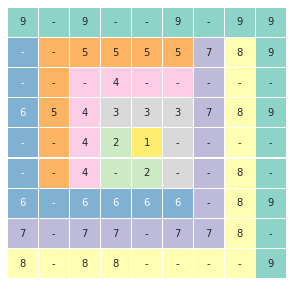

In [5]:
start = time.perf_counter()
test = Matrix(col_labels,row_labels)
test.solve()
solved,matrix = test.final
stop =  time.perf_counter()
print('Solution took {:0.4f} seconds\n'.format((stop-start)))
sol_print(solved,matrix)
print("row check",np.sum(solved*matrix,axis=1)-row_labels)
print("col check",np.sum(solved*matrix,axis=0)-col_labels)
print("\n")

### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2016/06/may16_solution.png" width="500" height="600">

In [11]:
# Few failed attempts at speeding up
# below some useful test grids
# then try to 
    
correct = np.array([[9, 9, 9, 9, 9, 9, 9, 9, 9],
                    [6, 5, 5, 5, 5, 5, 7, 8, 9],
                    [6, 5, 4, 4, 4, 4, 7, 8, 9],
                    [6, 5, 4, 3, 3, 3, 7, 8, 9],
                    [6, 5, 4, 2, 1, 3, 7, 8, 9],
                    [6, 5, 4, 2, 2, 3, 7, 8, 9],
                    [6, 6, 6, 6, 6, 6, 7, 8, 9],
                    [7, 7, 7, 7, 7, 7, 7, 8, 9],                          
                    [8, 8, 8, 8, 8, 8, 8, 8, 9]])

solved=np.array([[9, 0, 9, 0, 0, 9, 0, 9, 9],
                 [0, 0, 5, 5, 5, 5, 7, 8, 9],
                 [0, 0, 0, 4, 0, 0, 0, 0, 0],
                 [6, 5, 4, 3, 3, 3, 7, 8, 9],
                 [0, 0, 4, 2, 1, 0, 0, 0, 0],
                 [0, 0, 4, 0, 2, 0, 0, 8, 0],
                 [6, 0, 6, 6, 6, 6, 0, 8, 9],
                 [7, 0, 7, 7, 0, 7, 7, 8, 0],
                 [8, 0, 8, 8, 0, 0, 0, 0, 9]]
        

In [42]:
# Having limited coins does not reduce the count but slows down the calc due to extra computation
def limited_coins(n,min_coin):
    cs = []
    for i in range(9,min_coin-1,-1):
        cs.append((i,i))
    r = [1] + [0] * n
    for c, k in cs:
        rs = r[:]
        for i in range(c, n+1):
            rs[i] += rs[i-c]
            r[i] += rs[i-c] - (0 if i<c*(k+1) else rs[i-c*(k+1)])
    if r[n]== 0:
        return False
    else:
        return True
        

limited_coins(45,9)

True

In [43]:
# Backtracking is WAY too slow - gets slower by an order of magnitude as we increase the size

test_hooks = np.array([[1,2,3,4,5,6,7],
                       [2,2,3,4,5,6,7],
                       [3,3,3,4,5,6,7],
                       [4,4,4,4,5,6,7],
                       [5,5,5,5,5,6,7],
                       [6,6,6,6,6,6,7],
                       [7,7,7,7,7,7,7]])

test_correct = np.array([[1,2,3,4,0,6,0],
                         [2,0,3,4,0,6,7],
                         [3,0,0,4,0,6,0],
                         [0,0,0,4,0,6,7],
                         [5,5,5,5,5,6,0],
                         [0,0,0,0,0,6,7],
                         [7,0,7,0,7,0,7] ])  
shape = 7

row_labels = np.sum(test_correct,axis=1)
print(row_labels)
col_labels = np.sum(test_correct,axis=0)
print(col_labels)

def solve_matrix(y,solution = np.ones((shape,shape),dtype = int)*-1):
        for row in range(shape):
            for col in range(shape):
                #print(row,col,solution)
                if solution[row,col] == -1:
                    for digit in range(2):
                        if possible(row,col,digit,solution,y):
                            solution[row,col] = digit
                            solve_matrix(y,solution=solution)
                            solution[row,col] = -1
                    return
        print("SOLVED")        
        print(solution*y)
    
def possible(row,col,digit,solution,y):
        num = y[row,col]
        #check counts
        if digit == 1:
            #print("count check: count {} num{}\n".format(np.sum((y == num)* (solution ==1)),num ),solution)
            if  np.sum((y == num)* (solution ==1)) > num-1:
                #print("count fail")
                return False
        
        if np.sum(solution[row,:]==-1) == 1:
            #print("row check : row {} col {} sum {} row label {}\n".format(row,col,np.sum(solution[row,:]*y[row,:]) + 2* num,row_labels[row]),solution)
            if np.sum(solution[row,:]*y[row,:]) + num * (1+digit)  != row_labels[row]:
                #print("row fail")
                return False
                
        if np.sum(solution[:,col]==-1) == 1:
            #print("col check : row {} col {} sum {} row label {}\n".format(row,col,np.sum(solution[:,col]*y[:,col]) +  2* num,row_labels[row]),solution)
            if np.sum(solution[:,col]*y[:,col]) +  num *(1+digit)  != col_labels[col]:
                #print("col fail")
                return False    
            
        #print("pass",digit)    
        return True
    
start = time.perf_counter() 
solve_matrix(test_hooks)
stop =  time.perf_counter()
print('Solution took {:0.4f} seconds\n'.format((stop-start)))

[16 22 13 17 31 13 28]
[18  7 18 21 12 36 28]
SOLVED
[[1 2 3 4 0 6 0]
 [2 0 3 4 0 6 7]
 [3 0 0 4 0 6 0]
 [0 0 0 4 0 6 7]
 [5 5 5 5 5 6 0]
 [0 0 0 0 0 6 7]
 [7 0 7 0 7 0 7]]
Solution took 5.5520 seconds

